In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, average_precision_score, precision_recall_curve
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

np.random.seed(99)

def bootstrap_pr(y_true, y_prob, n_bootstraps=1000, random_state=42, max_workers=60):
    np.random.seed(random_state)
    n = len(y_true)
    boot_precision = []
    boot_recall = []
    boot_ap = []  # Collect AP values for bootstrapped samples

    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    def compute_metrics(indices):
        y_true_boot = y_true[indices]
        y_prob_boot = y_prob[indices]
        precision, recall, _ = precision_recall_curve(y_true_boot, y_prob_boot)
        
        # Sort recall and precision to ensure monotonicity
        sort_indices = np.argsort(recall)
        recall = recall[sort_indices]
        precision = precision[sort_indices]
        
        ap = average_precision_score(y_true_boot, y_prob_boot)  # Compute AP for this bootstrap sample
        return {'precision': precision, 'recall': recall, 'ap': ap}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        with tqdm(total=n_bootstraps, desc="Bootstrap Progress") as pbar:
            for _ in range(n_bootstraps):
                indices = np.random.choice(n, n, replace=True)
                futures.append(executor.submit(compute_metrics, indices))
                pbar.update(1)

        for future in futures:
            res = future.result()
            boot_precision.append(res['precision'])
            boot_recall.append(res['recall'])
            boot_ap.append(res['ap'])  

    return boot_precision, boot_recall, boot_ap  

model1 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_1.pkl")
model2 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_2.pkl")
model3 = joblib.load("/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/predictions_config_3.pkl")

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.79it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.27it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.36it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.10it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

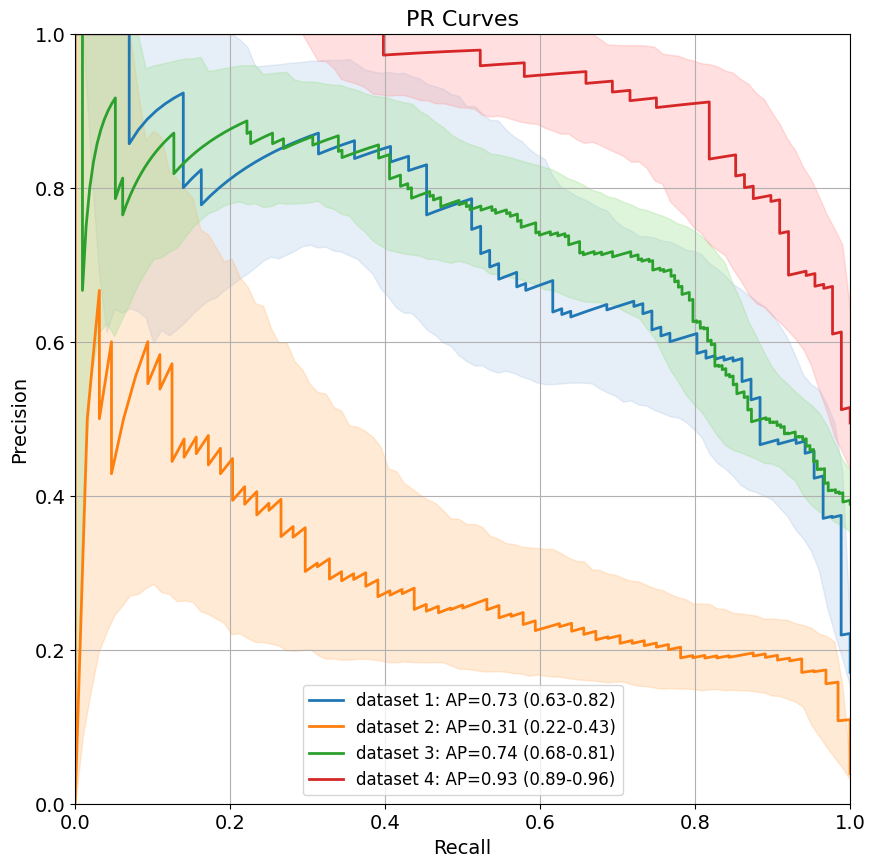

In [2]:
true_labels_list = [model1['y_test'], 
                    model1['y1'], 
                    model1['y2'], 
                    model1['y3']]
prob_estimates_list = [model1['y_prob'], 
                       model1['y_prob1'], 
                       model1['y_prob2'], 
                       model1['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

# Finalize plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.03it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.74it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.52it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.51it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

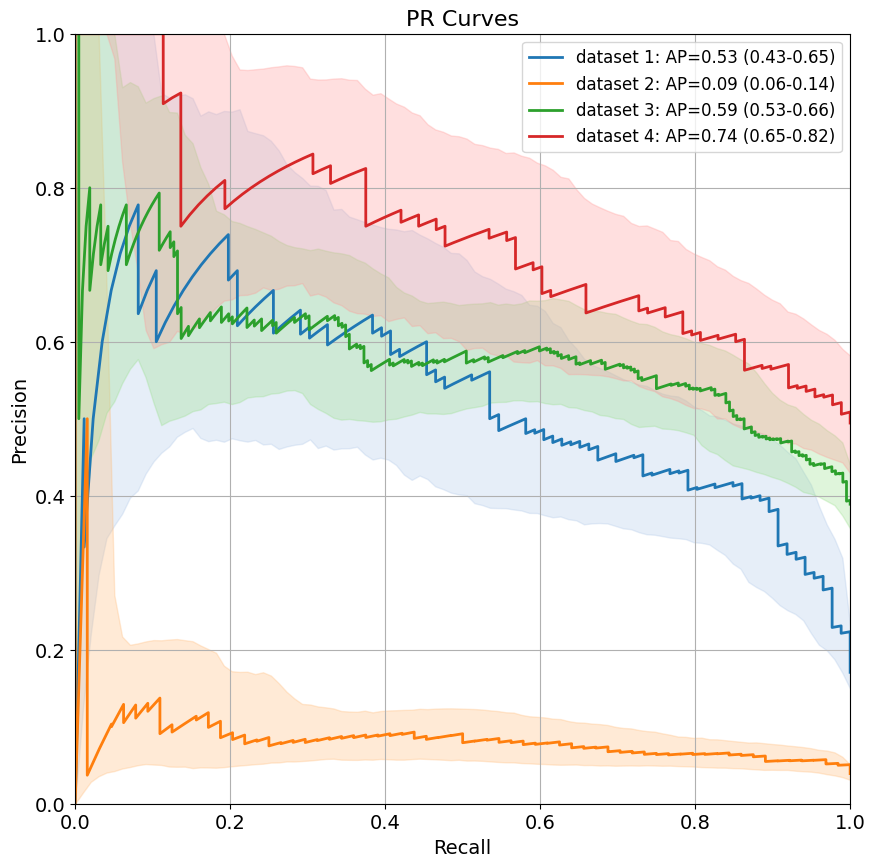

In [3]:
true_labels_list = [model2['y_test'], 
                    model2['y1'], 
                    model2['y2'], 
                    model2['y3']]
prob_estimates_list = [model2['y_prob'], 
                       model2['y_prob1'], 
                       model2['y_prob2'], 
                       model2['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

# Finalize plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.05it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.13it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.44it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.84it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

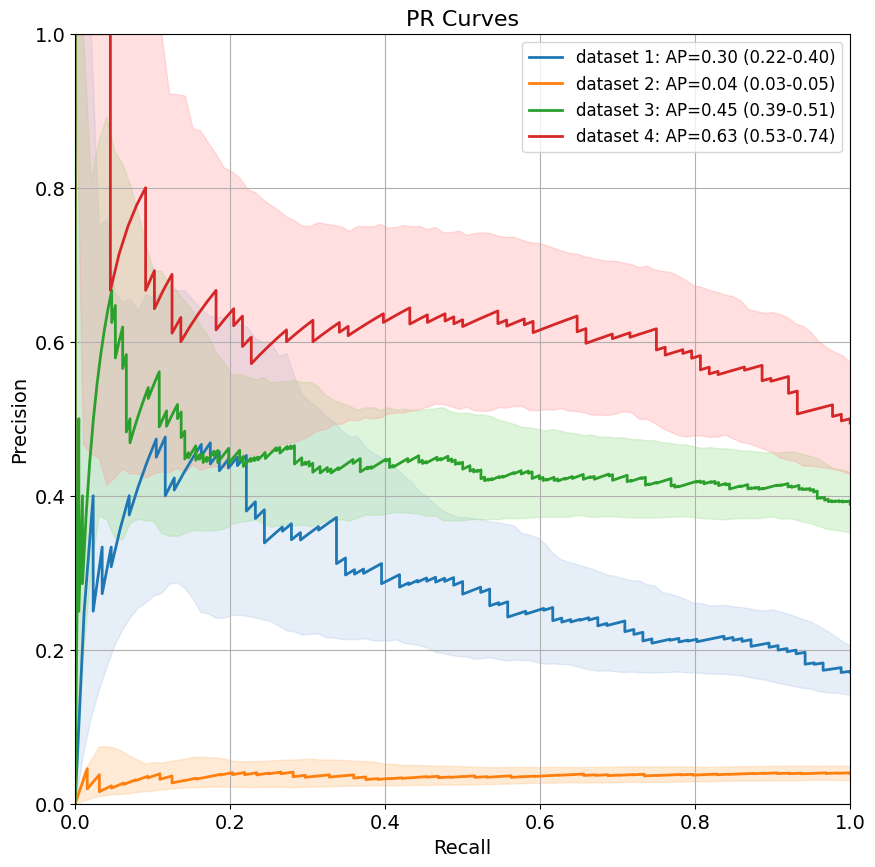

In [4]:
true_labels_list = [model3['y_test'], 
                    model3['y1'], 
                    model3['y2'], 
                    model3['y3']]
prob_estimates_list = [model3['y_prob'], 
                       model3['y_prob1'], 
                       model3['y_prob2'], 
                       model3['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

# Finalize plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.36it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.33it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.60it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.46it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

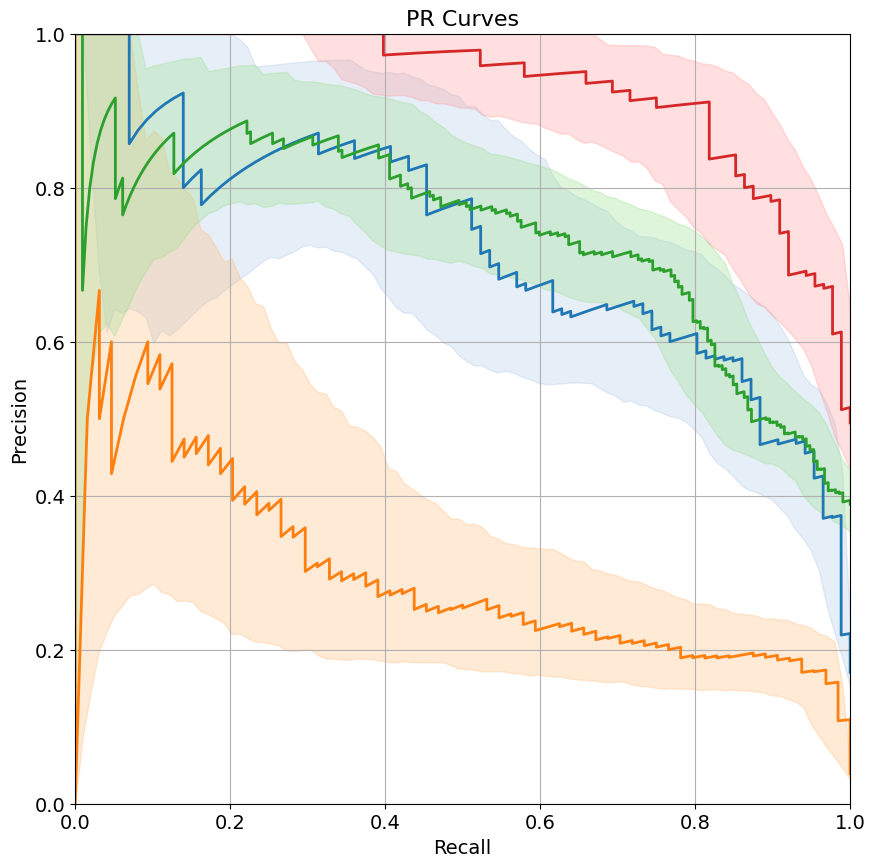

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.89it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.58it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.68it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.35it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

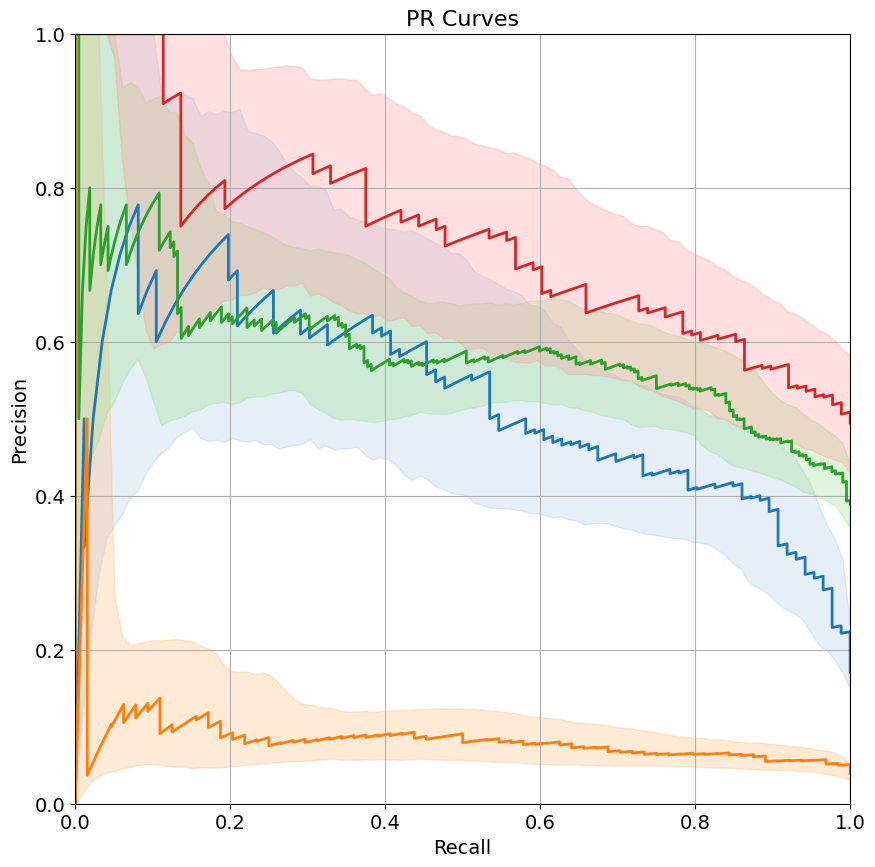

<Figure size 1000x1000 with 0 Axes>

Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.20it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.70it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.82it/s]


Bootstrap Progress: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.61it/s]


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'PR Curves')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

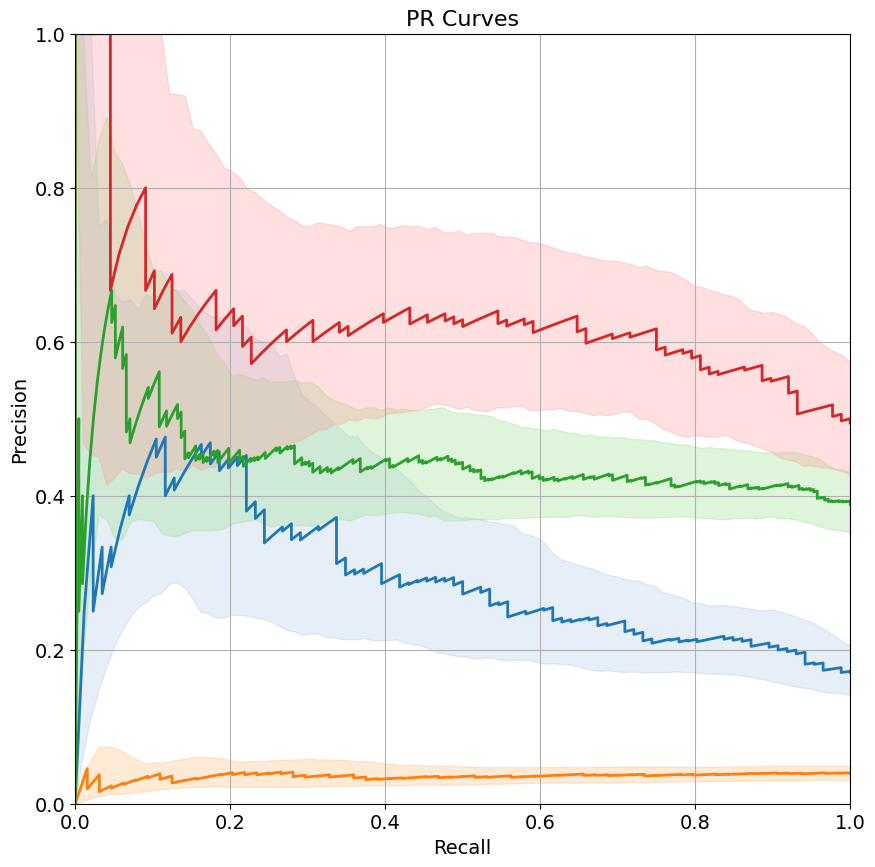

In [6]:
true_labels_list = [model1['y_test'], 
                    model1['y1'], 
                    model1['y2'], 
                    model1['y3']]
prob_estimates_list = [model1['y_prob'], 
                       model1['y_prob1'], 
                       model1['y_prob2'], 
                       model1['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/pr_curve_model1.tiff', dpi=300)
plt.show()

true_labels_list = [model2['y_test'], 
                    model2['y1'], 
                    model2['y2'], 
                    model2['y3']]
prob_estimates_list = [model2['y_prob'], 
                       model2['y_prob1'], 
                       model2['y_prob2'], 
                       model2['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/pr_curve_model2.tiff', dpi=300)
plt.show()

true_labels_list = [model3['y_test'], 
                    model3['y1'], 
                    model3['y2'], 
                    model3['y3']]
prob_estimates_list = [model3['y_prob'], 
                       model3['y_prob1'], 
                       model3['y_prob2'], 
                       model3['y_prob3']]

colors = plt.get_cmap('tab20')(np.arange(0, 20))
plt.figure(figsize=(10, 10))

for i, (y_true, y_prob) in enumerate(zip(true_labels_list, prob_estimates_list)):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    boot_precision, boot_recall, boot_ap = bootstrap_pr(y_true, y_prob, n_bootstraps=1000)
    ap_ci = np.percentile(boot_ap, [2.5, 97.5])
    
    # Interpolate bootstrapped precision-recall curves onto a common recall grid
    recall_grid = np.linspace(0, 1, 100)
    interp_precision = []
    for p, r in zip(boot_precision, boot_recall):
        # Ensure recall is sorted before interpolation
        sort_indices = np.argsort(r)
        r_sorted = r[sort_indices]
        p_sorted = p[sort_indices]
        interp_p = np.interp(recall_grid, r_sorted, p_sorted, left=1, right=0)
        interp_precision.append(interp_p)
    interp_precision = np.array(interp_precision)
    
    # Calculate confidence bands for precision
    lower_p = np.percentile(interp_precision, 2.5, axis=0)
    upper_p = np.percentile(interp_precision, 97.5, axis=0)
    
    # Plot results (show original AP and Bootstrap CI in the label)
    plt.plot(recall, precision, color=colors[2 * i], lw=2, 
             label=f'dataset {i+1}: AP={ap:.2f} ({ap_ci[0]:.2f}-{ap_ci[1]:.2f})')
    plt.fill_between(recall_grid, lower_p, upper_p, color=colors[2 * i + 1], alpha=0.3)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("PR Curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig('/home/luo_wenjin/data/BAH_PRS/version10/ml_dat/pr_curve_model3.tiff', dpi=300)
plt.show()